# Analysing info about driver's licenses

Hello, i am Iza and this is simple analysis i made to get used to working with data in Python. My aim is to answer some questions using data about newly granted driver licences in Poland.

## About the data

Datasets come from dane.gov.pl website. They contain info about newly granted driver licenses in Poland in both 2022 and 2023. They contain month, age, sex and number of licenses granted. Unfortunately this dataset don't contain much information, but we can still do some interesting stuff with it!

## Table of contents

1. [Data load and setup](#1-data-load-and-setup)
2. [In what months were the most driver's licenses granted? Are their numbers significantly higher in the summer?](#2-in-what-months-were-the-most-drivers-licenses-granted-are-their-numbers-significantly-higher-in-the-summer)
3. [How did the number of driving licenses obtained changed between 2022 and 2023? Is the difference significant?](#3-how-did-the-number-of-driving-licenses-obtained-changed-between-2022-and-2023-is-the-difference-significant) 
4. [What is the difference in the number of driving licenses obtained between men and women? Does age play a factor here?](#4-what-is-the-difference-in-the-number-of-driving-licenses-obtained-between-men-and-women-does-age-play-a-factor-here)
5. [Which age groups get the most driving licenses?](#5-which-age-groups-get-the-most-driving-licenses?)
6. Which voivodeships have the highest number of driving licenses obtained (per number of inhabitants)?
7. Conclusion


## 1. Data load and setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os


In [2]:
# all files that are in 'year folders'
csv_files_22 = [f for f in os.listdir('2022') if f.endswith('.csv')] 
csv_files_23 = [f for f in os.listdir('2023') if f.endswith('.csv')]
list1 = [] 
list2 = []

for file in csv_files_22:
    file_path = os.path.join('2022', file) 
    # loading contents of csv into dataframe
    df = pd.read_csv(file_path, encoding='utf-8', sep='|')  
    list1.append(df)

for file in csv_files_23:
    file_path = os.path.join('2023', file)  
    df = pd.read_csv(file_path, encoding='utf-8', sep='|')  
    list2.append(df)


While working with this data i encountered peculiar problem. In files about march and november 2023 there is different separator and it caused problems (fixed it manually in csv's)

In [3]:
# changing list of dataframes into one dataframe
df_2022 = pd.concat(list1, ignore_index=True)
df_2023 = pd.concat(list2, ignore_index=True)


In [4]:
df = pd.concat([df_2022, df_2023], ignore_index=True)
# separating year and month
df[['YEAR', 'MONTH']] = df['DATA_MC'].str.split('-', expand=True)
df.set_index(['YEAR', 'MONTH'], inplace=True)
df.drop(columns='DATA_MC', inplace=True)
# translating polish columns
df.rename(columns={'KOD_WOJ' : 'VOIV_CODE', 'WOJEWODZTWO' : 'VOIVODESHIP', 'PLEC' : 'GENDER', 'WIEK' : 'AGE', 'LICZBA' : 'NUMBER'}, inplace=True)
df = df.sort_index() 
df

VOIV_CODE              VOIVODESHIP GENDER  AGE  NUMBER
YEAR MONTH                                                        
2022 01             2        WOJ. DOLNOŚLĄSKIE      K   54       4
     01             2        WOJ. DOLNOŚLĄSKIE      K   47       5
     01             2        WOJ. DOLNOŚLĄSKIE      K   42       5
     01             2        WOJ. DOLNOŚLĄSKIE      K   20      89
     01             2        WOJ. DOLNOŚLĄSKIE      K   29      22
...               ...                      ...    ...  ...     ...
2023 12            32  WOJ. ZACHODNIOPOMORSKIE      M   18     275
     12            32  WOJ. ZACHODNIOPOMORSKIE      M   20      20
     12            32  WOJ. ZACHODNIOPOMORSKIE      M   19      51
     12            32  WOJ. ZACHODNIOPOMORSKIE      M   41       3
     12            32  WOJ. ZACHODNIOPOMORSKIE      M   43       4

[30592 rows x 5 columns]

## 2. In what months were the most driver's licenses granted? Are their numbers significantly higher in the summer?

In [5]:
# sum of records for each month, changed to df from series
num_months = df.groupby(['YEAR', 'MONTH'])['NUMBER'].sum().to_frame()
num_months


NUMBER
YEAR MONTH        
2022 01      27012
     02      27907
     03      32601
     04      26385
     05      26505
     06      26473
     07      24892
     08      25230
     09      27334
     10      29929
     11      29504
     12      26791
2023 01      28385
     02      26273
     03      30403
     04      24373
     05      23823
     06      24521
     07      24700
     08      24294
     09      20476
     10      24462
     11      19605
     12      25005

At a first glance those numbers do not differ significantly. Let's see it on a chart to analyze better!

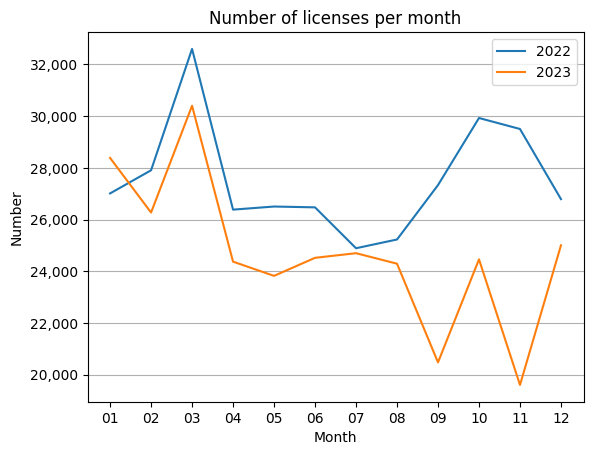

In [6]:
#reseting index for easier plotting 
num_months.reset_index(inplace=True)

for year in num_months['YEAR'].unique():
    subset = num_months[num_months['YEAR'] == year] # subset of data for one year
    plt.plot(subset['MONTH'], subset['NUMBER'], label=year) 
    
plt.legend()
plt.title('Number of licenses per month')
plt.xlabel('Month')
plt.ylabel('Number')
plt.grid(axis='y') # only horizontal grid
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}')) # showing numbers in thousands on y axis
plt.show()



Thanks to the chart, we can draw unexpected conclusions:
- the number of driver's licenses granted is quite significantly higher in 2022 than in 2023 (i will dive into this next chapter)
- the month in which the most driver's licenses were granted is surprisingly March, and this is true in both 22 and 23. The high number is also in October
- in 2022 the least number of driver's licenses were granted during the vacation season, and in 2023 in November and September. 

All in all, it might be a good idea to book your exam for March! Also summer months does not have more licenses granted which felt more intuitative - it may be because of holiday season.


## 3. How did the number of driving licenses obtained changed between 2022 and 2023? Is the difference significant?

In [7]:
sum_2022, sum_2023 = df.groupby(['YEAR'])['NUMBER'].sum()
print(sum_2022, sum_2023)

330563 296320


In [8]:
print(sum_2022 - sum_2023)

34243


In [9]:
print(round(((sum_2023 - sum_2022) / sum_2022) * 100, 2))

-10.36


We can see that as many as 34,000 more driver's licenses were granted in 2022 relative to 2023. That's quite a lot! Percentage difference is -10,36% 

In [10]:
print(df.loc[('2023', '01')]['NUMBER'].sum() - df.loc[('2022', '01')]['NUMBER'].sum())

1373


Also one interesting detail that we can learn from the chart is that January is the only month where 2023 had more licenses granted (though only by ~1,300)

## 4. What is the difference in the number of driving licenses obtained between men and women? Does age play a factor here?

In [16]:
#K is woman, M is man
gender_sum = df.groupby(['GENDER'])['NUMBER'].sum()
gender_sum.head()

GENDER
K    311352
M    315531
Name: NUMBER, dtype: int64

As we can see overall number of licenses is nearly equally divided by gender. There is slightly more male new drivers, but it is not a significant difference.

Text(0, 0.5, '')

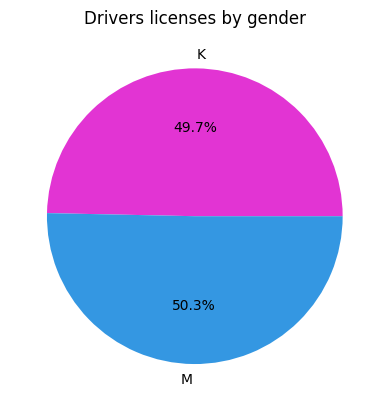

In [12]:
gender_sum.plot(kind='pie',colors=['#E234D3','#3497E2'], autopct='%1.1f%%')
plt.title('Drivers licenses by gender')
plt.ylabel('') 

That is a really strange looking pie chart. But now let's dive into age of new drivers.

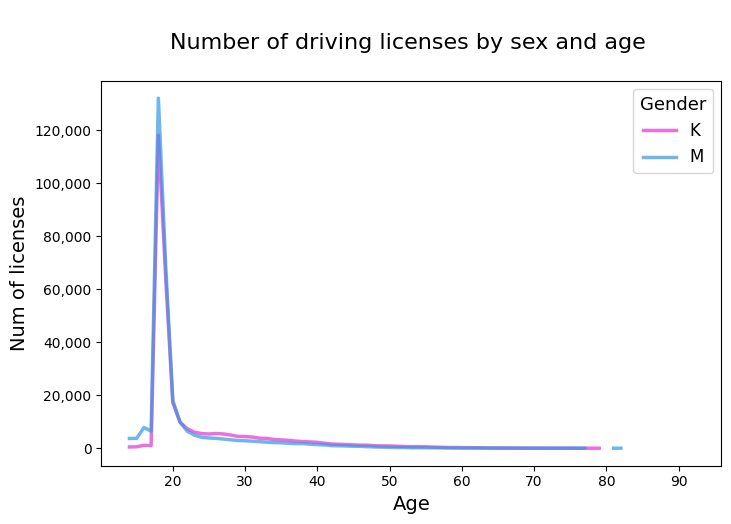

In [20]:
dfp = df.pivot_table(index='AGE',columns='GENDER', values='NUMBER', aggfunc='sum')
ax = dfp.plot(figsize=(8, 5),  linestyle='-', alpha=0.7, linewidth=2.5, color=['#E234D3', '#3497E2'])
ax.set_title('\nNumber of driving licenses by sex and age \n', fontsize=16)
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Num of licenses', fontsize=14)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}')) 

ax.legend(title='Gender', title_fontsize='13', fontsize='12')


As we showed before gender does not play a big factor here - the only thing worth noting is that there are more males who got driving license in 18-20 age range (but more women in 22-35!). Also most people become drivers when there are in 18-20 age range which is to be expected after all (in Poland you can have car driver license when you turn 18)

Now let's see who was the olderst driver

In [14]:
df.groupby(['GENDER'])['AGE'].max()

GENDER
K    84
M    92
Name: AGE, dtype: int64

84 year old woman and 92 year old man - now that is really uncommon and remarkable!

## 5. Which age groups get the most driving licenses?

In [67]:
age_sum = df.groupby(['AGE'])['NUMBER'].sum()
age_sum.head()

AGE
14      4146
15      4262
16      8920
17      7392
18    250041
Name: NUMBER, dtype: int64

Now for a little recap let's plot linear graph again

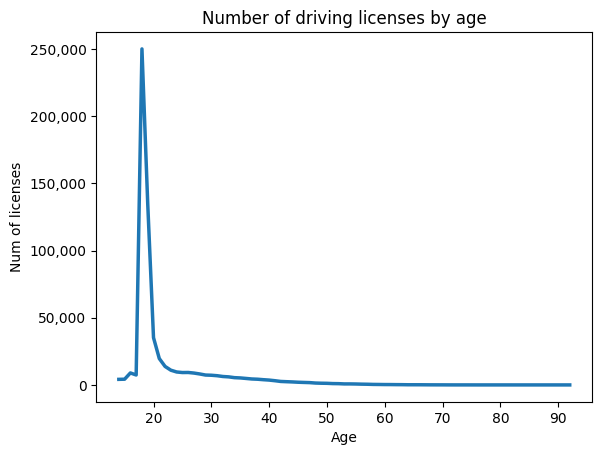

In [68]:
plt.plot(age_sum.index, age_sum.values, linestyle='-', linewidth=2.5) 
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))
plt.xlabel("Age")
plt.ylabel("Num of licenses") 
plt.title("Number of driving licenses by age")
plt.show()

No surprise here - looks like eighteen year olds got the most driving licenses. But let's dive deeper.

In [69]:
age_sum['21+'] = age_sum[7:].sum()
age_sum = age_sum.drop(age_sum.index[7:-1])
age_sum['14-17'] = age_sum[14] + age_sum[15] + age_sum[16] + age_sum[17]
age_sum = age_sum.drop(age_sum.index[0:4])
print(age_sum)

AGE
18       250041
19       134834
20        35178
21+      182110
14-17     24720
Name: NUMBER, dtype: int64


Text(0, 0.5, '')

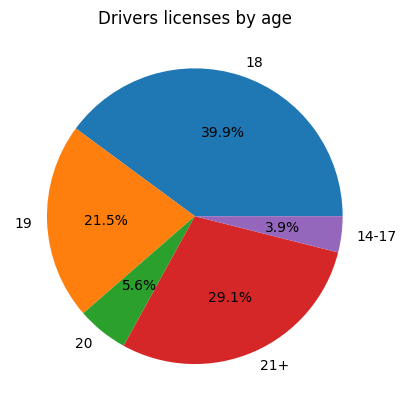

In [71]:
age_sum.plot(kind='pie', autopct='%1.1f%%')
plt.title('Drivers licenses by age')
plt.ylabel('') 

Now it looks more clear! Seems like eighteen year olds dominate this graph - 40% of all granted licenses are theirs. Nineteen year olds took about 20% of the graph. The rest is people who are 20+ and 14-17 year olds.